##**AIM:**

The aim of this notebook is to train a stacked LSTM model and then forcast stock prices. Here, we are using AAPL dataset for training purpose. 

In [ ]:
# Imports
import math as m
import pandas as pd
import numpy as np
import pandas_datareader as pdr
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import matplotlib.pyplot as plt

In [ ]:
# use pandas data reader to get data from api
df = pdr.get_data_tiingo('AAPL',api_key="bbf81df7a4a2c30a59c65ade30399446efd3e635")

In [ ]:
# convert it to a csv because of API throttle limit
df.to_csv('AAPL.csv')

In [ ]:
# read csv
df = pd.read_csv('AAPL.csv')

In [ ]:
# peek data
df

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2016-01-19 00:00:00+00:00,96.66,98.6500,95.50,98.41,53087747,22.385352,22.846214,22.116710,22.790632,212350988,0.0,1.0
1,AAPL,2016-01-20 00:00:00+00:00,96.79,98.1897,93.42,95.10,72334416,22.415459,22.739613,21.635005,22.024074,289337664,0.0,1.0
2,AAPL,2016-01-21 00:00:00+00:00,96.30,97.8800,94.94,97.06,52161463,22.301980,22.667890,21.987020,22.477988,208645852,0.0,1.0
3,AAPL,2016-01-22 00:00:00+00:00,101.42,101.4600,98.37,98.63,65800467,23.487714,23.496977,22.781369,22.841582,263201868,0.0,1.0
4,AAPL,2016-01-25 00:00:00+00:00,99.44,101.5300,99.21,101.52,51794525,23.029169,23.513189,22.975903,23.510873,207178100,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,AAPL,2021-01-11 00:00:00+00:00,128.98,130.1700,128.50,129.19,100620880,128.980000,130.170000,128.500000,129.190000,100620880,0.0,1.0
1255,AAPL,2021-01-12 00:00:00+00:00,128.80,129.6900,126.86,128.50,90440255,128.800000,129.690000,126.860000,128.500000,90440255,0.0,1.0
1256,AAPL,2021-01-13 00:00:00+00:00,130.89,131.4500,128.49,128.76,88636831,130.890000,131.450000,128.490000,128.760000,88636831,0.0,1.0
1257,AAPL,2021-01-14 00:00:00+00:00,128.91,131.0000,128.76,130.80,90221755,128.910000,131.000000,128.760000,130.800000,90221755,0.0,1.0


In [ ]:
# we'll forecast on the basis of closing values
df_new = df.reset_index()['close']

In [ ]:
df_new

0        96.66
1        96.79
2        96.30
3       101.42
4        99.44
         ...  
1254    128.98
1255    128.80
1256    130.89
1257    128.91
1258    127.14
Name: close, Length: 1259, dtype: float64

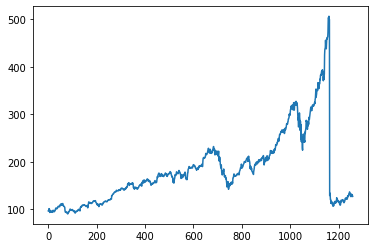

In [ ]:
# stock price from 19/01/2016 to 15/01/2021
plt.plot(df_new)
plt.show()

In [ ]:
np.array(df_new).reshape(-1,1)

array([[ 96.66],
       [ 96.79],
       [ 96.3 ],
       ...,
       [130.89],
       [128.91],
       [127.14]])

In [ ]:
# apply min max scaler
from sklearn.preprocessing import MinMaxScaler
# scaling the data b/w 0 to 1 as LSTM are sensitive to scale of data as inputs should be of comparable range
scaler = MinMaxScaler(feature_range=(0,1))
# reshaping as we need a 2d matrix here
df_new = scaler.fit_transform(np.array(df_new).reshape(-1,1))

In [ ]:
df_new

array([[0.01520144],
       [0.01551413],
       [0.01433554],
       ...,
       [0.09753458],
       [0.0927721 ],
       [0.08851473]])

In [ ]:
# apply train test split
# As here we are dealing with time series data we cannot simply apply cross validation or random seed 
# instead we have to divide data in two parts based on date
train_data_size = int(len(df_new)*0.7)
train_data, test_data = df_new[:train_data_size,:],df_new[train_data_size:len(df_new),:1]

In [ ]:
len(train_data)

881

In [ ]:
len(test_data)

378

In [ ]:
# Utility function to generate data frames from numpy arrays based on time_steps
def generate_df(data,time_step=100):
  dataX,dataY = [],[]
  for i in range(len(data)-time_step-1):
    dataX.append(data[i:(i+time_step),0])
    dataY.append(data[i+time_step,0])
  return np.array(dataX),np.array(dataY)

In [ ]:
X_train, y_train = generate_df(train_data)
X_test, y_test = generate_df(test_data)

In [ ]:
print(X_test.shape), print(y_test.shape)
print(X_train.shape), print(y_train.shape)

(277, 100)
(277,)
(780, 100)
(780,)


(None, None)

In [ ]:
# reshaping the inputs for lstm i.e., [samples, time steps, features]
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
# Sequential Model: A plain stack of layers where each layer has exactly one input tensor and one output tensor / does not have multiple inputs or outputs
# return_sequences(True): As we want to have a sequence for the output, not just a single vector
# dense layer: Each neuron in previous layer is connected to all the neurons in this layer
# adam optimiser: uses both momentum smoothening and RMSPROP (Upgraded version of adagrad for prevention of high alpha value which may lead to very low learning rate)
# loss: mean_squared_error as we are using regression here, in case of classification we could have binary_cross_entropy
lstmModel = Sequential()
lstmModel.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
lstmModel.add(LSTM(50,return_sequences=True))
lstmModel.add(LSTM(50))
lstmModel.add(Dense(1))
lstmModel.compile(loss = 'mean_squared_error',optimizer = 'adam')

In [ ]:
lstmModel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstmModel.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64)

Epoch 1/100
13/13 [==============================] - 4s 88ms/step - loss: 0.0129 - val_loss: 0.0581
Epoch 2/100
13/13 [==============================] - 0s 20ms/step - loss: 0.0022 - val_loss: 0.0308
Epoch 3/100
13/13 [==============================] - 0s 18ms/step - loss: 7.7534e-04 - val_loss: 0.0245
Epoch 4/100
13/13 [==============================] - 0s 18ms/step - loss: 4.8429e-04 - val_loss: 0.0243
Epoch 5/100
13/13 [==============================] - 0s 18ms/step - loss: 4.1055e-04 - val_loss: 0.0231
Epoch 6/100
13/13 [==============================] - 0s 18ms/step - loss: 3.4968e-04 - val_loss: 0.0224
Epoch 7/100
13/13 [==============================] - 0s 18ms/step - loss: 3.5751e-04 - val_loss: 0.0220
Epoch 8/100
13/13 [==============================] - 0s 18ms/step - loss: 4.0518e-04 - val_loss: 0.0215
Epoch 9/100
13/13 [==============================] - 0s 18ms/step - loss: 3.5487e-04 - val_loss: 0.0205
Epoch 10/100
13/13 [==============================] - 0s 18ms/step - los

In [ ]:
# predictions and performance metrices
train_preds=lstmModel.predict(X_train)
test_preds=lstmModel.predict(X_test)
# To find RMSE performance metrics we have to perform inverse scaling
train_preds=scaler.inverse_transform(train_preds)
test_preds=scaler.inverse_transform(test_preds)

In [ ]:
# train data RMSE
from sklearn.metrics import mean_squared_error
m.sqrt(mean_squared_error(y_train,train_preds))

164.42102059751554

In [ ]:
# test data RMSE
m.sqrt(mean_squared_error(y_test,test_preds))

282.67351767278666

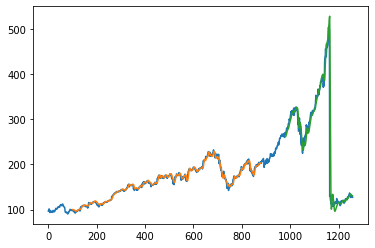

In [ ]:
# shift train and test preds for plotting
step=100
trainPredictPlot = np.empty_like(df_new)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[step:len(train_preds)+step, :] = train_preds

testPredictPlot = np.empty_like(df_new)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_preds)+(step*2)+1:len(df_new)-1, :] = test_preds

plt.plot(scaler.inverse_transform(df_new))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
# Forcast for next 300 days based on our lstm model
print(len(test_data))
# taking the data for last 100 days
X_input=test_data[278:].reshape(1,-1)
X_input.shape

378


(1, 100)

In [ ]:
new_x_input = list(list(X_input)[0])

In [ ]:
len(new_x_input)

100

In [ ]:
X_input

array([[0.98366807, 1.        , 0.98544799, 0.9834997 , 0.09308479,
        0.10544799, 0.09876127, 0.07345761, 0.07365003, 0.05407096,
        0.06489477, 0.0556825 , 0.05209862, 0.06016837, 0.06061335,
        0.0524113 , 0.04810583, 0.03968731, 0.04748046, 0.05164161,
        0.04036079, 0.04300661, 0.0527721 , 0.05921828, 0.05712568,
        0.06126278, 0.06361996, 0.05455201, 0.06292243, 0.05488876,
        0.05950692, 0.05924233, 0.06405292, 0.08192423, 0.07398677,
        0.07420325, 0.07304871, 0.06898376, 0.06167168, 0.06535177,
        0.06381239, 0.06111846, 0.0594107 , 0.05943476, 0.06316296,
        0.05017438, 0.06008419, 0.044546  , 0.04432952, 0.04834636,
        0.05919423, 0.06900782, 0.06819002, 0.06248948, 0.06164762,
        0.07011425, 0.06944077, 0.06956103, 0.07206254, 0.06987372,
        0.06660253, 0.06806975, 0.06494287, 0.05654841, 0.05972339,
        0.06179194, 0.06313891, 0.06905592, 0.07788334, 0.07874925,
        0.07841251, 0.07675286, 0.08036079, 0.08

In [ ]:
fifty_day_predictions = []
for i in range(300):
  x_input = X_input.reshape((1, 100,1))
  yhat = lstmModel.predict(x_input)
  k = x_input.tolist()[0]
  k.append(yhat[0])
  fifty_day_predictions.append(list(yhat[0]))
  k = k[1:]
  X_input = np.array(k)

In [ ]:
fifty_day_predictions

[[0.09696437],
 [0.09710232],
 [0.097653136],
 [0.098530315],
 [0.09960176],
 [0.10075565],
 [0.10191669],
 [0.103042014],
 [0.10411107],
 [0.10511704],
 [0.10606072],
 [0.10694699],
 [0.10778291],
 [0.10857654],
 [0.10933643],
 [0.11007087],
 [0.110787794],
 [0.111494295],
 [0.11219636],
 [0.11289894],
 [0.11360575],
 [0.114319414],
 [0.1150415],
 [0.11577272],
 [0.116513036],
 [0.11726191],
 [0.118018396],
 [0.11878129],
 [0.11954934],
 [0.12032128],
 [0.12109588],
 [0.12187208],
 [0.12264904],
 [0.123426],
 [0.12420247],
 [0.12497809],
 [0.1257527],
 [0.12652628],
 [0.12729882],
 [0.12807046],
 [0.12884142],
 [0.12961182],
 [0.13038196],
 [0.13115199],
 [0.13192213],
 [0.1326925],
 [0.13346325],
 [0.13423446],
 [0.1350062],
 [0.13577852],
 [0.1365514],
 [0.1373248],
 [0.13809876],
 [0.13887316],
 [0.13964802],
 [0.14042325],
 [0.14119881],
 [0.14197464],
 [0.1427507],
 [0.14352694],
 [0.14430334],
 [0.14507985],
 [0.14585645],
 [0.14663313],
 [0.14740986],
 [0.14818661],
 [0.1489634

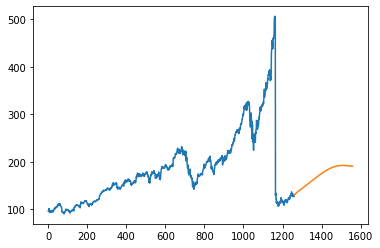

In [ ]:
day_new=np.arange(1,1260)
day_pred=np.arange(1260,1560)

plt.plot(day_new,scaler.inverse_transform(df_new))
plt.plot(day_pred,scaler.inverse_transform(fifty_day_predictions))
plt.show()

Using Biderctional LSTM:

In [ ]:
from tensorflow.keras.layers import Bidirectional
bidirectionalLstmModel = Sequential()
bidirectionalLstmModel.add(Bidirectional(LSTM(50,return_sequences=True,input_shape=(100,1))))
bidirectionalLstmModel.add(Bidirectional(LSTM(50,return_sequences=True)))
bidirectionalLstmModel.add(Bidirectional(LSTM(50)))
bidirectionalLstmModel.add(Dense(1))
bidirectionalLstmModel.compile(loss = 'mean_squared_error',optimizer = 'adam')

In [ ]:
bidirectionalLstmModel.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64)

Epoch 1/100
13/13 [==============================] - 9s 165ms/step - loss: 0.0131 - val_loss: 0.0488
Epoch 2/100
13/13 [==============================] - 0s 34ms/step - loss: 0.0015 - val_loss: 0.0336
Epoch 3/100
13/13 [==============================] - 0s 35ms/step - loss: 8.5593e-04 - val_loss: 0.0235
Epoch 4/100
13/13 [==============================] - 0s 32ms/step - loss: 4.1678e-04 - val_loss: 0.0195
Epoch 5/100
13/13 [==============================] - 0s 37ms/step - loss: 3.1280e-04 - val_loss: 0.0168
Epoch 6/100
13/13 [==============================] - 1s 49ms/step - loss: 2.3369e-04 - val_loss: 0.0154
Epoch 7/100
13/13 [==============================] - 0s 35ms/step - loss: 2.3810e-04 - val_loss: 0.0148
Epoch 8/100
13/13 [==============================] - 0s 32ms/step - loss: 1.9235e-04 - val_loss: 0.0149
Epoch 9/100
13/13 [==============================] - 0s 33ms/step - loss: 2.0613e-04 - val_loss: 0.0140
Epoch 10/100
13/13 [==============================] - 0s 32ms/step - lo

In [ ]:
# predictions and performance metrices for bidirectional lstm model
bidirectional_train_preds=bidirectionalLstmModel.predict(X_train)
bidirectional_test_preds=bidirectionalLstmModel.predict(X_test)
# To find RMSE performance metrics we have to perform inverse scaling
bidirectional_train_preds=scaler.inverse_transform(bidirectional_train_preds)
bidirectional_test_preds=scaler.inverse_transform(bidirectional_test_preds)

In [ ]:
# train data RMSE for bidirectional lstm
from sklearn.metrics import mean_squared_error
m.sqrt(mean_squared_error(y_train,bidirectional_train_preds))

162.44907262120913

In [ ]:
# test data RMSE for bidirectional lstm
m.sqrt(mean_squared_error(y_test,bidirectional_test_preds))

314.5475493741209

**Note**

Here bidirectional lstm won't even help at the first place as our aim was to forecast stock prices, moreover normal stacked lstm performs better than birectional (Compare the RMSE vales)

**Results for stacked LSTM model**

  RMSE value on test set: 282.67

  RMSE value on train set: 164.42